<a href="https://colab.research.google.com/github/estebanhernandezr/Entregas-Semanales/blob/master/Scripts_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **imports**

In [164]:
pip install Bio

In [165]:
pip install Levenshtein

In [166]:
import psycopg2
import numpy as np
import pandas as pd
import scipy.optimize
from Bio import Phylo, AlignIO
import matplotlib.pyplot as plt
from Levenshtein import distance
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor


## **functions**

### **data base connection**

In [167]:
def db_selection(what, where):
    engine = None
    resultDataFrame = None
    try:
        engine = psycopg2.connect(
            database = "UDriveDB",
            user = "UDriveAdmin",
            password = "UDriveAdmin10",
            host = "database-1.ct0kpzfxpmof.us-east-1.rds.amazonaws.com",
            port = "5432"
        )
        data = pd.read_sql_query("SELECT "+what+" FROM "+where+";", engine)
        resultDataFrame = pd.DataFrame(data)
    except(Exception, psycopg2.DatabaseError) as error:
        print("Error:", error)
        raise(ValueError(Exception))
    finally:
          if engine is not None:
              engine.close()
          return resultDataFrame

### **visualize the general state of the data base**

In [168]:
def count_column_values(dataframe, col):
    return dataframe[col].value_counts()

def plot_count(dataframe, col):
    plt.title(col)
    conteo = pd.DataFrame(count_column_values(dataframe, col))
    plt.barh(conteo.index.values.tolist(), conteo.loc[:, col])
    plt.plot(conteo.loc[:, col], conteo.index.values.tolist(), '-o', color='orange')
    plt.xlabel('repetición del valor')
    plt.ylabel('valor')
    plt.show()

def plot_count_frecuencies(dataframe, col):
    bar_width = 0.5

    plt.title(col)
    conteo = pd.DataFrame(count_column_values(dataframe, col))
    #print(conteo)
    conteo_conteo = pd.DataFrame(count_column_values(conteo, col))
    conteo_conteo = conteo_conteo.sort_values(by=[col])
    #print(conteo_conteo)
    plt.bar(conteo_conteo.index.values.tolist(), conteo_conteo.loc[:, col], width=bar_width/2)
    plt.plot(conteo_conteo.index.values.tolist(), conteo_conteo.loc[:, col], '-o', color='orange')
    plt.axvline(x=np.dot(conteo_conteo.index.values.tolist(), conteo_conteo.loc[:, col])/conteo.shape[0], color='r') # Promedio muestral
    plt.xlabel('tamaño de la repetición')
    plt.ylabel('repetición de la repetición')
    plt.show()

In [169]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

def plot_exponential_fit(dataframe, col):
    conteo = pd.DataFrame(count_column_values(dataframe, col))
    #print(conteo)
    conteo_conteo = pd.DataFrame(count_column_values(conteo, col))
    conteo_conteo = conteo_conteo.sort_index(axis=0)
    
    xs = conteo_conteo.index.values
    ys = conteo_conteo[col]
    
    try:
        # perform the fit
        p0 = (2000, .1, 50) # start with values near those we expect
        params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
        m, t, b = params
        sampleRate = 20_000 # Hz
        tauSec = (1 / t) / sampleRate

        # determine quality of the fit
        squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
        squaredDiffsFromMean = np.square(ys - np.mean(ys))
        rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
        print(f"R² = {rSquared}")

        # plot the results
        plt.plot(xs, ys, '.', label="data")
        plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
        plt.title("Fitted Exponential Curve")

        # inspect the parameters
        print(f"Y = {m} * e^(-{t} * x) + {b}")
        print(f"Tau = {tauSec * 1e6} µs")
    except:
        print("¡CORRECTO!")

In [170]:
def visualize_general_info(dataframe, col):
    plot_count(dataframe, col)
    plot_exponential_fit(dataframe, col)
    plot_count_frecuencies(dataframe, col)

### **visualize clusters of coincidences**

In [179]:
def distance_matrix(dataframe, col):
    List1 = dataframe[col]
    List2 = dataframe[col]

    Matrix = np.zeros((len(List1),len(List2)),dtype=int)

    for i, elem1 in enumerate(List1):
      for j, elem2 in enumerate(List2):
          Matrix[i,j] = distance(elem1, elem2)

    return Matrix

def lower_triangular(matrix):
    new_filas = []
    for fila in matrix:
        new_fila = []
        for c in fila:
            new_fila.append(c)
            if c == 0:
                break
        new_filas.append(new_fila)
    return new_filas

In [172]:
def visualize_data_similarities(dataframe, col):
    dataframe = dataframe.drop_duplicates(col)
    matrix = distance_matrix(dataframe, col)
    matrix = lower_triangular(matrix)
    distMatrix = DistanceMatrix(names=dataframe[col].tolist(), matrix=matrix)
    constructor = DistanceTreeConstructor()
    UGMATree = constructor.upgma(distMatrix)

    Phylo.draw(UGMATree)

### **visualize state of quantitative data**



In [173]:
def boxplot_quantitative(dataframe, col):
    boxplot = dataframe.boxplot(column=[col])
    print(boxplot)

## **main**

In [177]:
def main():
    usuariosDF = db_selection('*', 'Usuario')
    visualize_general_info(dataframe=usuariosDF, col='pwd')
    #boxplot_quantitative(dataframe=usuariosDF, col='calificacion')
    visualize_data_similarities(dataframe=usuariosDF, col='nombre')

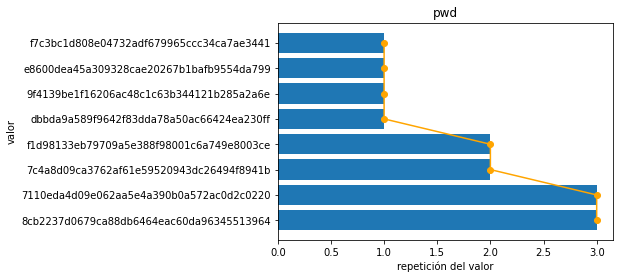

R² = 0.7499490957471189
Y = -4909.344917336187 * e^(--0.0002035971093535739 * x) + 4914.011163393559
Tau = -245583.05448810788 µs


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


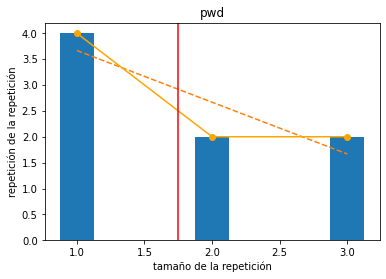

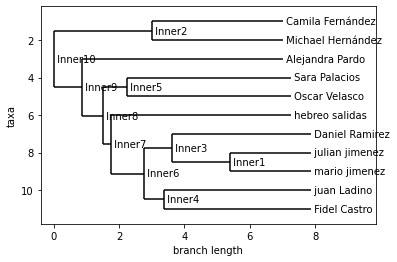

In [180]:
main()

## **tests suite**

In [176]:
usuariosDF = db_selection('*', 'Usuario')
usuariosDF

,id_usuario,nombre,apellido,celular,pwd,email,calificacion,picture,create_by,create_on
0,8,Fidel Castro,None,3008512552,8cb2237d0679ca88db6464eac60da96345513964,fidelin@gmail.com,3,None,sys,03:27:53.028703
1,9,Oscar Velasco,None,3222328874,7c4a8d09ca3762af61e59520943dc26494f8941b,chiquillo@gmail.com,3,None,sys,05:09:18.669253
2,10,juan Ladino,None,3058996370,f1d98133eb79709a5e388f98001c6a749e8003ce,juane.ladino0209@gmail.com,3,None,sys,05:09:37.448520
3,11,Oscar Velasco,None,3222328874,dbbda9a589f9642f83dda78a50ac66424ea230ff,oscarvch@hotmail.es,3,None,sys,15:43:31.177930
4,12,hebreo salidas,None,3058996370,f1d98133eb79709a5e388f98001c6a749e8003ce,hebreo@gmail.com,3,None,sys,15:43:47.646820
5,13,Michael Hernández,None,3158624052,9f4139be1f16206ac48c1c63b344121b285a2a6e,gerar1616@hotmail.com,3,None,sys,16:15:11.248332
6,15,mario jimenez,None,3005668965,8cb2237d0679ca88db6464eac60da96345513964,mario@urosario.com,3,None,sys,16:17:18.672690
7,18,Michael Hernández,None,3158624052,e8600dea45a309328cae20267b1bafb9554da799,gerard1616@hotmail.com,3,None,sys,16:19:50.462029
8,19,Michael Hernández,None,3158624052,7110eda4d09e062aa5e4a390b0a572ac0d2c0220,gerard1616@yahoo.com,3,None,sys,16:19:57.545973
9,20,Camila Fernández,None,3280646738,8cb2237d0679ca88db6464eac60da96345513964,camila@gmail.com,3,None,sys,16:24:17.090778
